<a href="https://colab.research.google.com/github/VictorDreke/Data-Science-for-Finance/blob/master/LSTM_for_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pH Neutralization plant using LSTM network
This notebook will be used to develop a digital twin of the pH Neutralization plant located at the University of Sao Paulo. 
In this case, the **digital twin** is developed using an LSTM network with the Keras Framework. We use data from a CSV file to estimate the **LSTM** and another CSV file to validate the model. 
In this notebook, some of the training hyperparameters were chosen based on trial and error and suggestion from the Keras documentation.
The aim of this notebook is to imitate the System Identification procedure proposed by (Ljung, 1997) for the SISO system. 

## Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
import time

For LSTM model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

## Load training data
Since this is a collab notebook, you will need to upload the CSV file called 'pH_GBN_Data_Reference.csv'. This file is contained in the Github repository.


As a csv file is loaded using pandas.read_csv function and creating a DataFrame.

In [ ]:

file = '/content/pH_GBN_Data_Reference.csv'
train = pd.read_csv(file)

In [ ]:
train.head()

,SP,Level
0,7.0,6.996475
1,7.0,6.996475
2,7.0,6.991562
3,7.0,6.991562
4,7.0,6.996475


## Plot training data
In the following section the data used for Identification is plotted. As commonly sugested by Ljung and Stoica, we use an pesistent excitating signal as an input to generate the response from the pH Neutralization plant. In this case, we selected and GBN design to this plant in (Christiam, 2017). Using a GBN should ensure a better representation of trainsent response of the plant. 

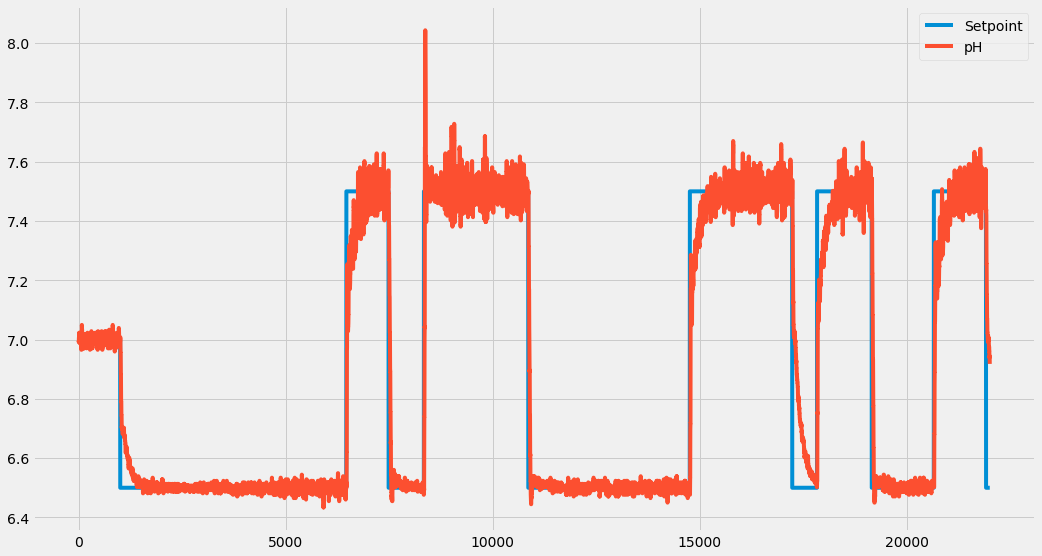

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train['SP'], label='Setpoint')
plt.plot(train['Level'], label='pH')
plt.legend()

## Pre-process data
Working with LSTM, it is recommend to normalize the data. 
In this case, we use **MinMaxScaler** to set values between -1 and 1. 

In [ ]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(train[['Level','SP']])

# Scale predicted value
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(train[['Level']])

## Function to reshape the data
As a SISO system but with the unique characteristics of being simulated with a LSTM, we need to reshape the data. In this case, we use two inputs: stepoint, process variable (pH).

In [ ]:
def dividing_data_for_lstm(Xs, Ys, window=70):
  X=[]
  Y=[]
  for i in range(window, len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])
  # Reshape data to format accepted by LSTM
  X, Y = np.array(X), np.array(Y)
  return X, Y



In [ ]:
X, Y = dividing_data_for_lstm(Xs, Ys, window=295)
X.shape

(21706, 295, 2)

## Create and Train LSTM model

In [ ]:


# Initialize LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['mape','mse'])

# Allow for early exit 
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=2)

# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(X, Y, epochs = 20, batch_size = 800, callbacks=[es], verbose=1, validation_split=0.15)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Epoch 1/20
24/24 [==============================] - 95s 4s/step - loss: 0.0658 - mape: 199.8851 - mse: 0.0658 - val_loss: 0.0158 - val_mape: 102.0536 - val_mse: 0.0158
Epoch 2/20
24/24 [==============================] - 97s 4s/step - loss: 0.0139 - mape: 129.9029 - mse: 0.0139 - val_loss: 0.0086 - val_mape: 87.5101 - val_mse: 0.0086
Epoch 3/20
24/24 [==============================] - 93s 4s/step - loss: 0.0105 - mape: 116.7927 - mse: 0.0105 - val_loss: 0.0062 - val_mape: 68.8674 - val_mse: 0.0062
Epoch 4/20
24/24 [==============================] - 93s 4s/step - loss: 0.0089 - mape: 109.1339 - mse: 0.0089 - val_loss: 0.0044 - val_mape: 46.7834 - val_mse: 0.0044
Epoch 5/20
24/24 [==============================] - 94s 4s/step - loss: 0.0078 - mape: 95.5936 - mse: 0.0078 - val_loss: 0.0037 - val_mape: 32.6021 - val_mse: 0.0037
Epoch 6/20
24/24 [==============================] - 93s 4s/step - loss: 0.0073 - mape: 91.2492 - mse: 0.0073 - val_loss: 0.0036 - val_mape: 34.5451 - val_mse: 0.0036

## Plot loss
This plot helps us to visualize the loos in the training stage. Also, it gives us a clear idea of the peformance of the training. A decreasing slope indicates a better training.

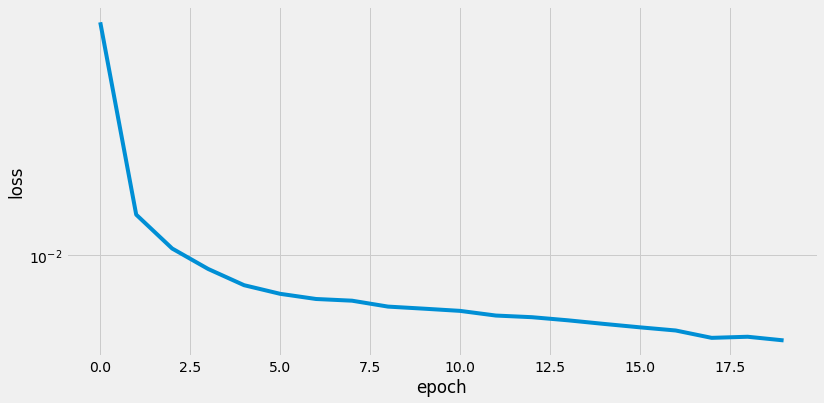

In [ ]:
plt.figure(figsize=(12,6))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')
plt.savefig('tclab_loss.png')
# Save the LSTM model
model.save('model.h5')

## Verifying the fit of the model
In this case, we use the trained LSTM to recreate the data used on the training stage. A good LSTM sholud mimic the data from the pH Neutralization plant

In [ ]:
Yp = model.predict(X)

# un-scale outputs
Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)
window = 295

No handles with labels found to put in legend.


Text(0, 0.5, 'SP')

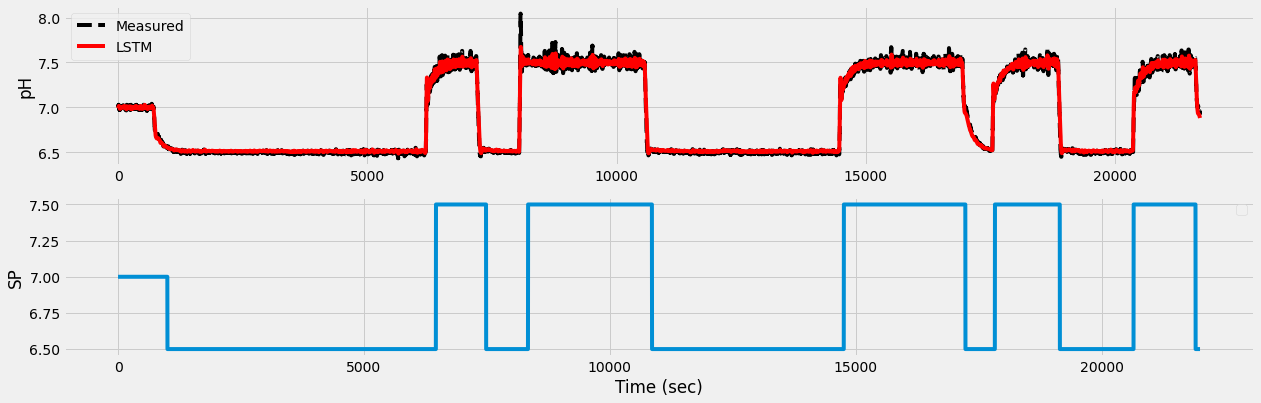

In [ ]:
plt.figure(figsize=(19,6))
plt.subplot(2,1,1)
# plt.plot(train['Time'][window:],Yu,'r-',label='LSTM')
# plt.plot(train['Time'][window:],Ym,'k--',label='Measured')
# plt.ylabel('Temperature (°C)')

plt.plot(Ym,'k--',label='Measured')
plt.plot(Yu,'r-',label='LSTM')
plt.ylabel('pH')
plt.legend()
plt.subplot(2,1,2)
# plt.plot(train['Q1'],label='heater (%)')
plt.plot(train['SP'])
plt.legend()
plt.xlabel('Time (sec)'); plt.ylabel('SP')
# plt.savefig('tclab_fit.png')

## Load trained model


In [ ]:

v = load_model('model.h5')
# Load training data
file = '/content/pH_Data_Reference.csv'
test = pd.read_csv(file)
Xt = test[['Level_PV','Level_SP']].values
Yt = test[['Level_PV']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

In [ ]:
Xti, Yti = dividing_data_for_lstm(Xts, Yts, window=295)

In [ ]:
# Verify the fit of the model
Ytp = model.predict(Xti)

# un-scale outputs
Ytu = s2.inverse_transform(Ytp)
Ytm = s2.inverse_transform(Yti)

## Ploting the test data
In this case, we plot the data from a step input signal, the response of the pH Neutralization and LSTM prediction.
If the model is a good representation the the LSTM prediction should mimc the pH process.

No handles with labels found to put in legend.


Text(0, 0.5, 'SP')

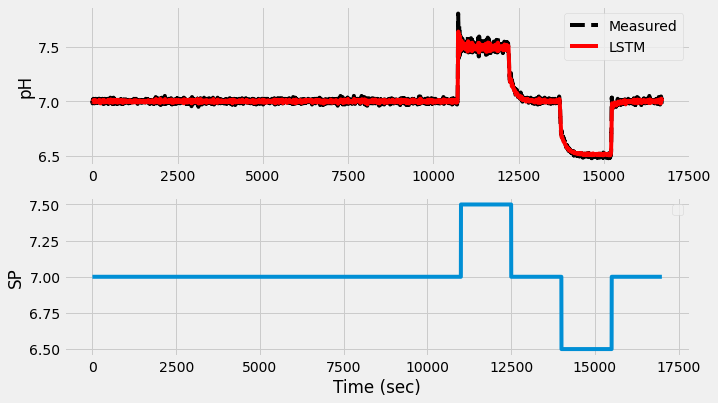

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
# plt.plot(test['Time'][window:],Ytu,'r-',label='LSTM Predicted')
# plt.plot(test['Time'][window:],Ytm,'k--',label='Measured')
# plt.legend()
# plt.ylabel('Temperature (°C)')
# plt.subplot(2,1,2)
# plt.plot(test['Time'],test['Q1'],'b-',label='Heater')
# plt.xlabel('Time (sec)'); plt.ylabel('Heater (%)')
# plt.legend()
# plt.savefig('tclab_validate.png')
# plt.plot(train['Time'][window:],Yu,'r-',label='LSTM')
# plt.plot(train['Time'][window:],Ym,'k--',label='Measured')
# plt.ylabel('Temperature (°C)')

plt.plot(Ytm,'k--',label='Measured')
plt.plot(Ytu,'r-',label='LSTM')
plt.ylabel('pH')
plt.legend()
plt.subplot(2,1,2)
# plt.plot(train['Q1'],label='heater (%)')
plt.plot(test['Level_SP'])
plt.legend()
plt.xlabel('Time (sec)'); plt.ylabel('SP')
# plt.savefig('tclab_fit.png')

## Using predicted values to predict next step

In [ ]:
Xtsq = Xts.copy()
for i in range(window,len(Xtsq)):
    Xin = Xtsq[i-window:i].reshape((1, window, 2))
    Xtsq[i][0] = v.predict(Xin)
    Yti[i-window] = Xtsq[i][0]

#Ytu = (Yti - s2.min_[0])/s2.scale_[0]
Ytu2 = s2.inverse_transform(Yti)

## Plotting the test data without the past pH values
This is an approach more similar with the classical statistical model prediction.

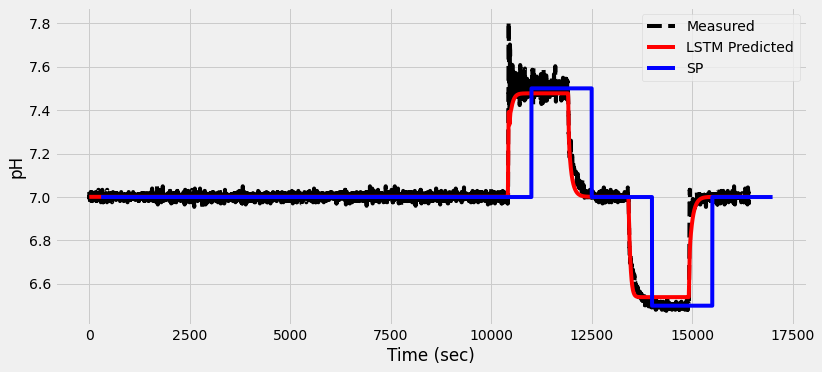

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
# plt.plot(test['Time'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(Ytm[window:],'k--',label='Measured')
plt.plot(Ytu2[window:],'r-',label='LSTM Predicted')
# plt.plot(test['Time'][window:],Ytm,'k--',label='Measured')
plt.legend()
# plt.ylabel('Temperature (°C)')
# plt.plot('pH')
# plt.subplot(2,1,2)
# plt.plot(test['Time'],test['Q1'],'b-',label='Heater')
plt.plot(test['Level_SP'][window:],'b-',label='SP')
plt.xlabel('Time (sec)'); plt.ylabel('pH')
plt.legend()
# plt.savefig('tclab_forecast.png')
plt.show()

In [ ]:

tr = pd.DataFrame(data=Ytu, columns=['1_step'])
tr2 = pd.DataFrame(data=Ytu2, columns=['Inf_step'])


In [ ]:
tr2.to_csv(path_or_buf='/content/pH_Inf_step.csv')